# Num-pyro example
from https://num.pyro.ai/en/stable/examples/bnn.html

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import warnings
import tyxe
from torch import nn
import pyro
from pyro import distributions as dist
from pyro.infer import MCMC, NUTS, SVI, Trace_ELBO, Predictive, TraceMeanField_ELBO, JitTraceMeanField_ELBO
from pyro.optim import Adam

In [2]:
# create artificial regression dataset
def get_data(N=50, D_X=3, sigma_obs=0.05, N_test=500):
    D_Y = 1  # create 1d outputs
    np.random.seed(0)
    X = np.linspace(-1, 1, N)
    X = np.power(X[:, np.newaxis], np.arange(D_X))
    W = 0.5 * np.random.randn(D_X)
    Y = np.dot(X, W) + 0.5 * np.power(0.5 + X[:, 1], 2.0) * np.sin(4.0 * X[:, 1])
    Y += sigma_obs * np.random.randn(N)
    Y = Y[:, np.newaxis]
    Y -= np.mean(Y)
    Y /= np.std(Y)

    assert X.shape == (N, D_X)
    assert Y.shape == (N, D_Y)

    X_test = np.linspace(-1.3, 1.3, N_test)
    X_test = np.power(X_test[:, np.newaxis], np.arange(D_X))

    return X, Y, X_test

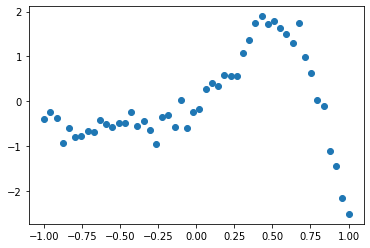

In [3]:
X, Y, X_test = get_data(D_X=2)
plt.scatter(X[:,1], Y)

In [27]:
def nonlin(x):
    return torch.tanh(x)
def model(X, Y=None, D_H=200, D_Y=1):
    N, D_X = X.shape
    
    # first layer
    w1 = pyro.sample("w1", dist.Normal(torch.zeros((D_X, D_H)), torch.ones((D_X, D_H))))
    z1 = nonlin(torch.matmul(X, w1))  # <= first layer of activations

    # second layer
    w2 = pyro.sample("w2", dist.Normal(torch.zeros((D_H, D_H)), torch.ones((D_H, D_H))))
    z2 = nonlin(torch.matmul(z1, w2))  # <= second layer of activations

    # sample final layer of weights and neural network output
    w3 = pyro.sample("w3", dist.Normal(torch.zeros((D_H, D_Y)), torch.ones((D_H, D_Y))))
    z3 = torch.matmul(z2, w3)  # <= output of the neural network

    # we put a prior on the observation noise
    prec_obs = pyro.sample("prec_obs", dist.Gamma(3.0, 1.0))
    sigma_obs = 1.0 / torch.sqrt(prec_obs)

    # observe data
    with pyro.plate("data", N):
        # note we use to_event(1) because each observation has shape (1,)
        pyro.sample("Y", dist.Normal(z3, sigma_obs).to_event(1), obs=Y)

In [32]:
pyro.clear_param_store()
data = torch.utils.data.TensorDataset(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(data, batch_size=100, shuffle=True)

adam_params = {"lr": 0.001, "betas": (0.90, 0.999)}
optimizer = Adam(adam_params)
guide = pyro.infer.autoguide.guides.AutoDiagonalNormal(model, init_scale=0.001 )
svi = SVI(model, guide, optimizer, loss= TraceMeanField_ELBO())#TraceMeanField_ELBO())

In [33]:
for step in range(2000):
    for x, y in dataloader:
        loss = svi.step(x, y, 200)
        if step % 1 == 0:
            print('[iter {}]  loss: {:.4f}'.format(step, loss))

[iter 0]  loss: 262553.0000
[iter 1]  loss: 262240.8750
[iter 2]  loss: 262210.5625
[iter 3]  loss: 262137.5938
[iter 4]  loss: 262237.5625
[iter 5]  loss: 262006.5625
[iter 6]  loss: 261727.4844
[iter 7]  loss: 262070.7969
[iter 8]  loss: 261994.6094
[iter 9]  loss: 261934.0938
[iter 10]  loss: 261820.8594
[iter 11]  loss: 261954.4062
[iter 12]  loss: 261594.6250
[iter 13]  loss: 261767.9531
[iter 14]  loss: 261436.4219
[iter 15]  loss: 261294.7500
[iter 16]  loss: 261478.7812
[iter 17]  loss: 261767.8594
[iter 18]  loss: 261498.2656
[iter 19]  loss: 261175.9062
[iter 20]  loss: 261560.0938
[iter 21]  loss: 261275.3125
[iter 22]  loss: 261237.9531
[iter 23]  loss: 261211.1406
[iter 24]  loss: 261396.3594
[iter 25]  loss: 261231.1719
[iter 26]  loss: 260873.3438
[iter 27]  loss: 261150.1875
[iter 28]  loss: 260807.8125
[iter 29]  loss: 260904.5938
[iter 30]  loss: 260717.9531
[iter 31]  loss: 260637.3281
[iter 32]  loss: 260962.9844
[iter 33]  loss: 261157.7812
[iter 34]  loss: 260826.

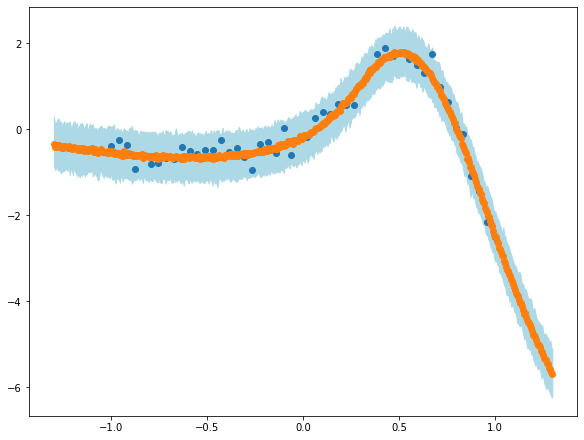

In [34]:
XT = torch.tensor(X_test, dtype=torch.float32)
predictive = pyro.infer.Predictive(model, guide=guide, num_samples=200)(XT, None, 200)
means = np.mean(predictive["Y"].data.cpu().numpy() ,0)
percs = np.percentile(predictive["Y"].data.cpu().numpy(), [5., 95.], axis=0).squeeze()
fig, ax = plt.subplots(figsize=(8, 6), constrained_layout=True)
ax.fill_between(X_test[:,1], percs[0,:], percs[1,:], color="lightblue")
ax.scatter(X[:,1], Y)
ax.scatter(X_test[:,1], means)



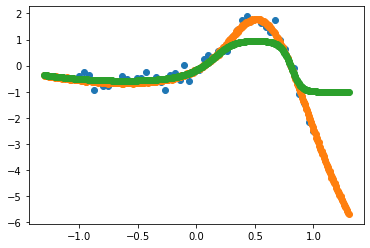

In [35]:
plt.scatter(X[:,1], Y)
plt.scatter(X_test[:,1], means)
plt.scatter(X_test[:,1], nonlin(nonlin(nonlin( XT.matmul(guide.median()["w1"]) ).matmul( guide.median()["w2"] )).matmul(guide.median()["w3"] )).data.cpu().numpy() )


In [95]:
pyro.clear_param_store()
mcmc = MCMC( pyro.infer.NUTS(model, jit_compile=True), num_samples=100)
mcmc.run(torch.tensor(X, dtype=torch.float32), torch.tensor(Y, dtype=torch.float32), 10)

Sample: 100%|██████████| 200/200 [03:35,  1.08s/it, step size=5.67e-03, acc. prob=0.960]


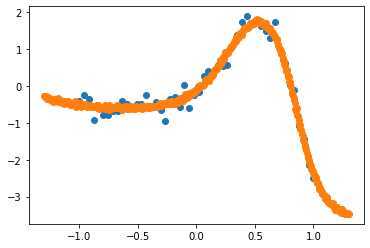

In [110]:
predictive = Predictive(model, mcmc.get_samples())(XT, None)
means = np.mean(predictive["Y"].data.cpu().numpy() ,0)
percs = np.percentile(predictive["Y"].data.cpu().numpy(), [5., 95.], axis=0)
plt.scatter(X[:,1], Y)
plt.scatter(X_test[:,1], means)
